In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pbp = pd.concat([pd.read_csv(f'pbp_data/play_by_play_{season}.csv.gz', low_memory=False) for season in range(2006,2022)])

In [3]:
sns.set(rc={'figure.figsize':(24,8.27)})

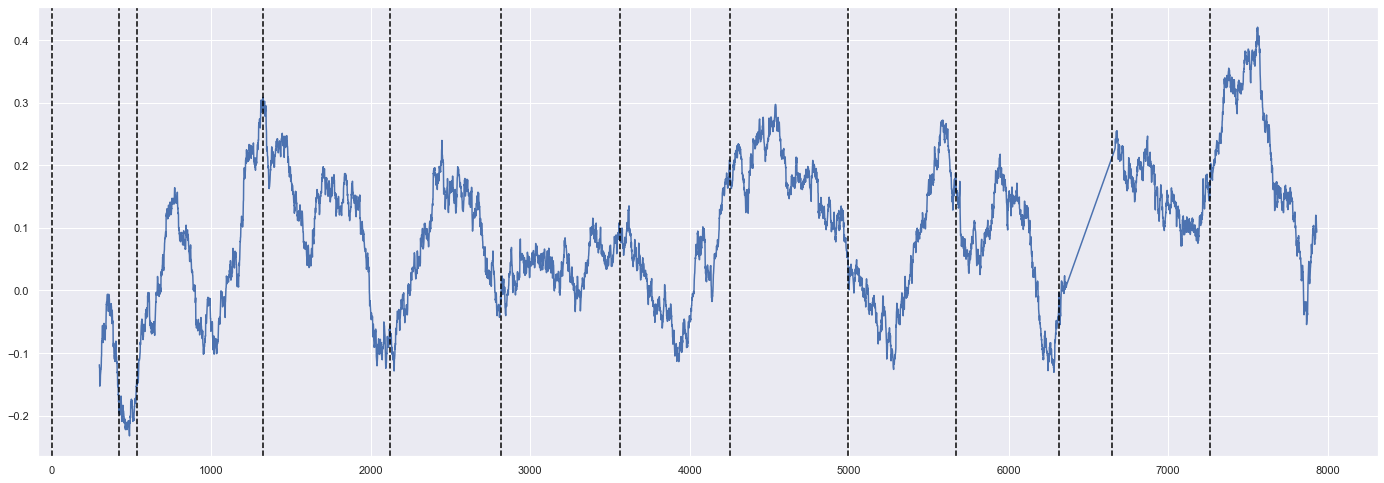

In [4]:
fig, ax = plt.subplots()
stafford = pbp.loc[pbp['passer']=='M.Stafford'].reset_index()
sns.lineplot(data=stafford.rolling(300).mean()['epa'], ax=ax)
markers = stafford.reset_index().groupby('season', as_index=False).agg({'level_0':'first'})
for i in range(len(markers)):
    ax.axvline(markers['level_0'][i], color='black', linestyle='--')
    # ax.text(x=markers['level_0'][i]+1, verticalalignment='bottom', s=markers['season'][i])

In [6]:
pbp['scramble_epa'] = np.where((pbp['qb_scramble']==1) & (pbp['qb_dropback']==1), pbp['epa'], 0)
pbp['sack_epa'] = np.where((pbp['sack']==1) & (pbp['qb_dropback']==1), pbp['epa'], 0)
pbp['incompletion_epa'] = np.where((pbp['incomplete_pass']==1) & (pbp['qb_dropback']==1), pbp['epa'], 0)
pbp['int_epa'] = np.where((pbp['interception']==1) & (pbp['qb_dropback']==1), pbp['epa'], 0)
pbp['aggression_epa'] = np.where((pbp['air_epa'].notnull()) & (pbp['xyac_epa'].notnull()) & (pbp['qb_dropback']==1), pbp['air_epa']+pbp['xyac_epa'], 0)
pbp['yacoe_epa'] = np.where((pbp['yac_epa'].notnull()) & (pbp['xyac_epa'].notnull()) & (pbp['complete_pass']==1) & (pbp['qb_dropback']==1), pbp['yac_epa']-pbp['xyac_epa'], 0)

components = ['scramble','sack','incompletion','int','aggression','yacoe']

games = pbp.groupby(['season','posteam','passer','game_id'], as_index=False).agg({**{'epa':'mean','qb_dropback':'sum'}, **{f'{component}_epa':'sum' for component in components}}).query('qb_dropback>10')
games['games_played'] = games.groupby(['posteam','passer']).game_id.transform('count')
games = games.loc[games.games_played>=16]

In [7]:
for component in components:
    games[f'{component}_value'] = games[f'{component}_epa']/games['qb_dropback']
    games[f'{component}_vaa'] = games[f'{component}_value']-games[f'{component}_value'].mean()
    games[f'weighted_{component}_vaa'] = games[f'{component}_vaa']*games['qb_dropback']

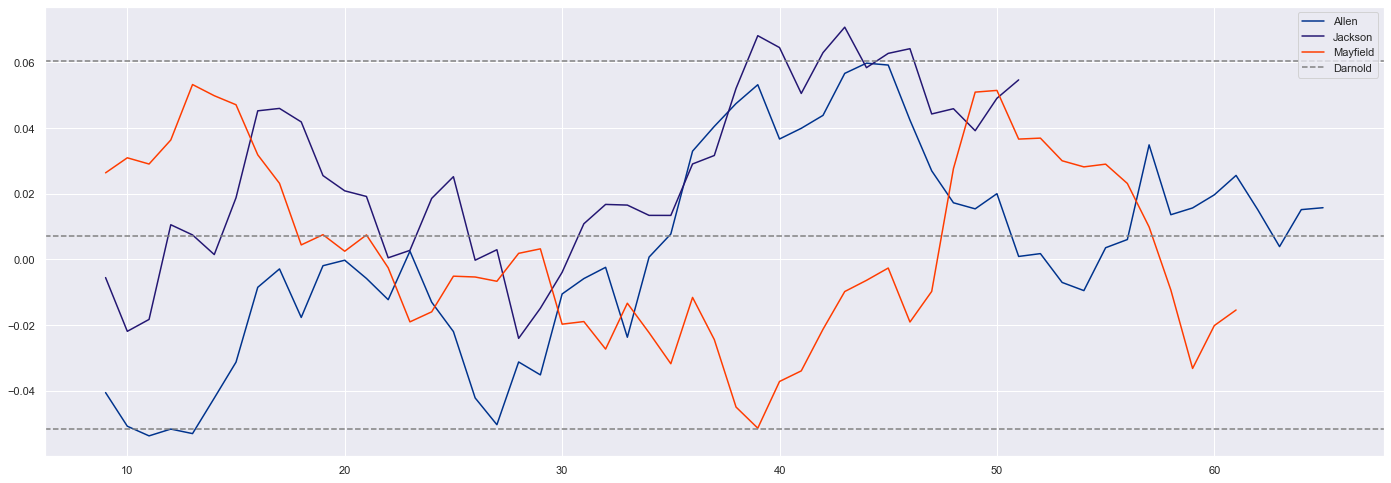

In [14]:
fig, ax = plt.subplots()
component = 'incompletion'
sns.lineplot(data=games.loc[(games['passer']=='J.Allen')].reset_index().rolling(10).mean()[f'{component}_vaa'], ax=ax, color='#00338D')
sns.lineplot(data=games.loc[games['passer']=='L.Jackson'].reset_index().rolling(10).mean()[f'{component}_vaa'], ax=ax, color='#241773')
sns.lineplot(data=games.loc[games['passer']=='B.Mayfield'].reset_index().rolling(10).mean()[f'{component}_vaa'], ax=ax, color='#FF3C00')
# sns.lineplot(data=games.loc[games['passer']=='S.Darnold'].reset_index().rolling(10).mean()[f'{component}_vaa'], ax=ax, color='#125740')
ax.axhline(games[f'{component}_vaa'].quantile(.25), color='gray', linestyle='--')
ax.axhline(games[f'{component}_vaa'].quantile(.5), color='gray', linestyle='--')
ax.axhline(games[f'{component}_vaa'].quantile(.75), color='gray', linestyle='--')
ax.legend(['Allen','Jackson', 'Mayfield', 'Darnold'])

In [64]:
seasons = games.groupby(['season','posteam','passer']).agg({**{f'weighted_{component}_vaa':'sum' for component in components}, 'qb_dropback':'sum'}).query('qb_dropback>300')
seasons['qb_dropback'] = seasons['qb_dropback'].astype(int)
seasons['epa'] = pbp.loc[pbp.qb_dropback==1].groupby(['season','posteam','passer']).agg({'epa':'mean'})
for component in components:
    seasons[f'{component}_vaa'] = seasons[f'weighted_{component}_vaa']/seasons['qb_dropback']
    seasons[f'{component}_pctile'] = (seasons[f'{component}_vaa'].rank(pct=True).round(2)*100).astype(int)
seasons.reset_index(inplace=True)
seasons[['season','passer']+[f'{component}_pctile' for component in components]+['qb_dropback','epa']].loc[seasons.passer=='M.Stafford'].style.background_gradient()

,season,passer,scramble_pctile,sack_pctile,incompletion_pctile,int_pctile,aggression_pctile,yacoe_pctile,qb_dropback,epa
81,2009,M.Stafford,46,67,4,0,46,84,408,-0.176126
135,2011,M.Stafford,36,84,31,48,38,84,756,0.142768
164,2012,M.Stafford,38,79,26,22,75,23,772,0.018107
196,2013,M.Stafford,50,88,8,13,72,92,670,0.071180
222,2014,M.Stafford,53,45,16,74,54,95,709,0.059950
247,2015,M.Stafford,56,41,78,48,3,75,663,0.025544
273,2016,M.Stafford,80,54,65,80,44,67,693,0.125022
302,2017,M.Stafford,61,4,69,65,43,74,632,0.061266
329,2018,M.Stafford,6,27,60,68,9,50,610,0.001084
358,2019,M.Stafford,45,32,47,87,96,30,317,0.216504


In [46]:
passers = games.groupby(['passer']).agg({**{f'weighted_{component}_vaa':'sum' for component in components}, 'qb_dropback':'sum'}).query('qb_dropback>300')
passers['qb_dropback'] = passers['qb_dropback'].astype(int)
passers['epa'] = pbp.loc[pbp.qb_dropback==1].groupby(['passer']).agg({'epa':'mean'})
for component in components:
    passers[f'{component}_vaa'] = passers[f'weighted_{component}_vaa']/passers['qb_dropback']
    passers[f'{component}_pctile'] = (passers[f'{component}_vaa'].rank(pct=True).round(2)*100).astype(int)
passers.reset_index(inplace=True)
passers[['passer']+[f'{component}_pctile' for component in components]+['qb_dropback','epa']].sort_values('epa',ascending=False).style.background_gradient()

,passer,scramble_pctile,sack_pctile,incompletion_pctile,int_pctile,aggression_pctile,yacoe_pctile,qb_dropback,epa
77,P.Mahomes,89,96,95,96,38,98,3067,0.277554
78,P.Manning,9,100,83,45,97,50,5928,0.208829
2,A.Rodgers,83,52,84,99,62,91,8837,0.205741
91,T.Brady,28,94,61,94,83,95,10832,0.197657
22,D.Brees,14,97,94,62,55,51,9823,0.179101
46,J.Herbert,67,89,56,82,19,85,1396,0.156671
79,P.Rivers,17,75,81,50,81,88,9131,0.156225
44,J.Garoppolo,18,31,97,26,42,100,1582,0.152505
60,L.Jackson,97,56,85,70,16,84,1735,0.149221
30,D.Watson,90,13,96,93,15,44,2255,0.148947


In [65]:
# columns: the data for which you want to find correlations and YoY stability
# groupby: the (single) variable by which you'd like to group by
# data: dataframe for which correlations/YoY stability are being found.
#       must contain all columns specified in first arg, as well as specified 
#       groupby col and 'season' col 
def year_to_year_corr(columns, groupby, data):
    cols = [groupby, 'season'] + columns 
    data = data[cols]
    ldata = data.groupby(by=groupby).shift(-1)
    data.columns = [groupby, 'prev_season'] + [f'prev_{col}' for col in columns]
    new_data = pd.concat((data, ldata), axis=1).dropna(subset=['season']).drop(columns=['prev_season','season'])
    tot_corr = new_data.corr(method='pearson')
    num_corr_cols = len(columns)
    corr = tot_corr.iloc[num_corr_cols:,num_corr_cols:]
    pred = tot_corr.iloc[0:num_corr_cols, num_corr_cols:]
    return corr,pred

corr, pred = year_to_year_corr([f'{component}_vaa' for component in components] + ['epa'], 'passer', seasons)
corr.style.background_gradient()

,scramble_vaa,sack_vaa,incompletion_vaa,int_vaa,aggression_vaa,yacoe_vaa,epa
scramble_vaa,1.000000,-0.282603,0.227206,0.262189,-0.279377,0.105721,0.144426
sack_vaa,-0.282603,1.000000,-0.033619,-0.052071,0.260801,0.010280,0.395376
incompletion_vaa,0.227206,-0.033619,1.000000,0.181393,-0.303783,0.169010,0.570170
int_vaa,0.262189,-0.052071,0.181393,1.000000,-0.257944,0.211465,0.502533
aggression_vaa,-0.279377,0.260801,-0.303783,-0.257944,1.000000,-0.010302,0.162805
yacoe_vaa,0.105721,0.010280,0.169010,0.211465,-0.010302,1.000000,0.504497
epa,0.144426,0.395376,0.570170,0.502533,0.162805,0.504497,1.000000


In [66]:
pred.style.background_gradient()

,scramble_vaa,sack_vaa,incompletion_vaa,int_vaa,aggression_vaa,yacoe_vaa,epa
prev_scramble_vaa,0.605809,-0.213895,0.122116,0.185989,-0.259778,0.021899,0.002846
prev_sack_vaa,-0.232361,0.384769,0.005207,-0.100717,0.129814,0.039453,0.113686
prev_incompletion_vaa,0.028228,0.072234,0.401930,0.126241,-0.098970,0.068145,0.316888
prev_int_vaa,0.194777,0.002523,0.201738,0.271816,-0.211690,0.002911,0.173269
prev_aggression_vaa,-0.144454,0.154684,-0.051194,-0.223302,0.440395,0.029236,0.087565
prev_yacoe_vaa,0.097349,0.085076,0.035950,0.205107,0.016146,0.369343,0.219509
prev_epa,0.006002,0.248933,0.300136,0.134252,0.078265,0.170029,0.406198


R: -0.396536334398259


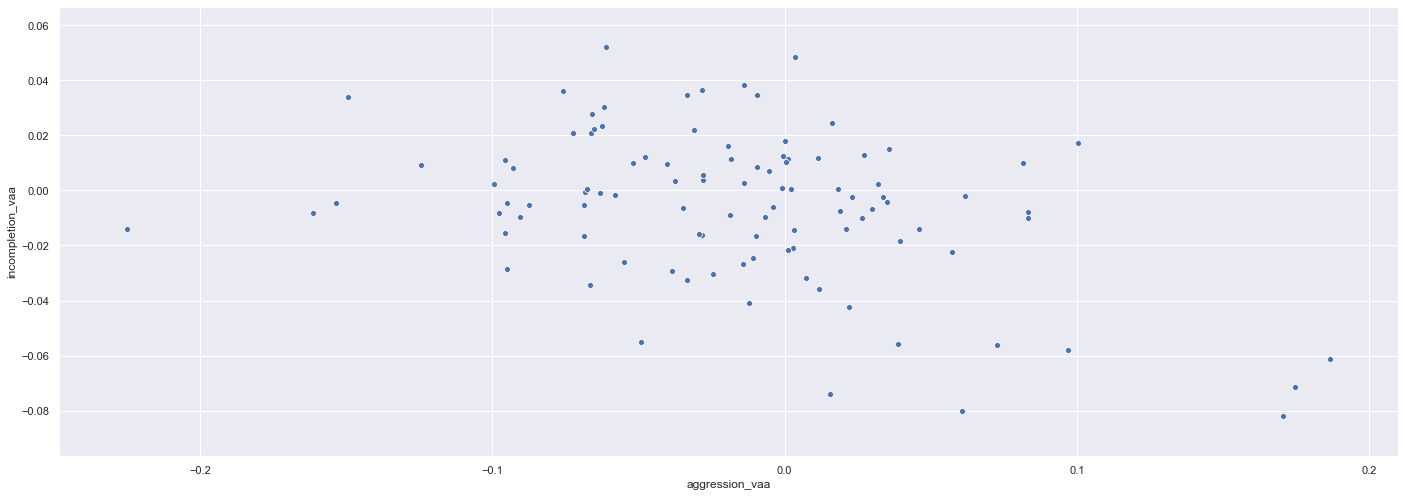

In [67]:
x='aggression_vaa'
y='incompletion_vaa'
sns.scatterplot(x=x,y=y,data=passers)
print("R: "+str(passers.corr().loc[x,y]))